In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import os
import json
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import random
import create_directory

# Load Data

## Train data

In [2]:
# Face Database
train_feature_path = os.path.join(create_directory.marvel_data_dir, "feature/Train/hog_openface")

with open(os.path.join(create_directory.recognition_model_dir, 'label2idx.json')) as json_file:
    label2idx = json.load(json_file)

label_idx = []
feature = []
label_feat_dict = {}
for i in os.listdir(train_feature_path):
    if i == ".DS_Store":
        continue
    # Ta bỏ qua tất cả các data có nhãn Unknown
    if i == "Unknown":
        continue
    label_feat_dict[i] = []
    for j in os.listdir(os.path.join(train_feature_path, i)):
        if j == ".DS_Store":
            continue
        feat=np.load(os.path.join(os.path.join(train_feature_path, i), j))
        feature.append(feat.reshape(128).tolist())
        label_feat_dict[i].append(feat.reshape(128).tolist()) 
        label_idx.append(label2idx[i])

In [3]:
data_path = os.path.join(create_directory.marvel_data_dir, "distance_face_recognition")
if not os.path.exists(data_path):
    os.makedirs(data_path)
with open(os.path.join(data_path, "feature.json"), "w") as outfile:
    json.dump(label_feat_dict, outfile)

## Test Data

In [4]:
# Test Data
test_feature_path = os.path.join(create_directory.marvel_data_dir, "feature/Test/hog_openface")
test_label_idx = []
test_feature = []
test_label_feat_dict = {}
for i in os.listdir(test_feature_path):
    if i == ".DS_Store":
        continue
    test_label_feat_dict[i] = []
    for j in os.listdir(os.path.join(test_feature_path, i)):
        if j == ".DS_Store":
            continue
        feat=np.load(os.path.join(os.path.join(test_feature_path, i), j))
        test_feature.append(feat.reshape(128).tolist())
        test_label_feat_dict[i].append(feat.reshape(128).tolist()) 
        test_label_idx.append(label2idx[i])

## Tạo data

In [5]:
# Big dataset: sử dụng cả dữ liệu train và dữ liệu test 
# (dữ liệu train làm tập cơ sở, dữ liệu test làm tập thử nghiệm)
x_train_big = feature
x_test_big = test_feature
y_train_big = label_idx
y_test_big = test_label_idx

In [6]:
# Small dataset: chỉ sử dụng dữ liệu train
# (dữ liệu train được chia ra làm 2 tập nhỏ hơn)
x_train_small, x_test_small, y_train_small, y_test_small = train_test_split(feature, label_idx, test_size=0.33,
                                                    random_state=4, stratify=label_idx)                

In [7]:
# Ta lấy ngẫu nhiên 1/3 dữ liệu trong nhãn unknown
unknown_feature_path = os.path.join(create_directory.marvel_data_dir, "feature/Train/hog_openface/Unknown")
unknown_label_idx = []
unknown_feature = []
for j in os.listdir(unknown_feature_path):
    if random.random()>0.33:
        continue
    if j == ".DS_Store":
        continue
    feat=np.load(os.path.join(unknown_feature_path, j))
    unknown_feature.append(feat.reshape(128).tolist())
    unknown_label_idx.append(label2idx["Unknown"])
x_test_small+=unknown_feature
y_test_small+=unknown_label_idx

# Face recognition

In [8]:
def neighbour_recognition(feat, train_labels, train_feats, threshold):
    candidate_label = []
    candidate_distance = []
    for label, vector in zip(train_labels, train_feats):
        distance = euclidean_distances(np.array(feat).reshape(1, -1), np.array(vector).reshape(1, -1))[0][0]
        if distance<threshold:
            candidate_label.append(label)
            candidate_distance.append(distance)
    if len(candidate_label)==0:
        return label2idx["Unknown"]
    else:
        df_candidate=pd.DataFrame({'Label': candidate_label})
        df_candidate_count = pd.DataFrame(df_candidate["Label"].value_counts().to_dict().items(), columns=['Label','Count'])
        list_candidate = list(df_candidate_count[df_candidate_count['Count']==max(df_candidate_count['Count'])]['Label'])
        if len(list_candidate) == 1:
            return max(candidate_label, key = candidate_label.count)
        else:
            df_candidate_distance=pd.DataFrame({'Label': candidate_label, 'Distance': candidate_distance})
            best_candidate = df_candidate_distance[df_candidate_distance['Label'].isin(list_candidate)].groupby('Label').mean().to_dict()['Distance']
            return min(best_candidate, key = best_candidate.get)

def nearest_recognition(feat, train_labels, train_feats, threshold):
    candidate_label = []
    candidate_distance = []
    for label, vector in zip(train_labels, train_feats):
        distance = euclidean_distances(np.array(feat).reshape(1, -1), np.array(vector).reshape(1, -1))[0][0]
        if distance<threshold:
            candidate_label.append(label)
            candidate_distance.append(distance)
    if len(candidate_label)==0:
        return label2idx["Unknown"]
    else:
        return candidate_label[candidate_distance.index(min(candidate_distance))]

In [9]:
threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# Lấy kết quả dự đoán ứng với các threshold tương ứng
def test_threshold(threshold_list, x_train, x_test, y_train, type):
    recognition_result = {}
    for i in threshold_list:
        print("Threshold: "+str(i))
        if type=="neighbour":
            recognition_result[i] = [neighbour_recognition(j, y_train, x_train, i) for j in x_test]
        if type=="nearest":
            recognition_result[i] = [nearest_recognition(j, y_train, x_train, i) for j in x_test]
    return recognition_result

# Plot confusion matrix
idx2label = {y: x for x, y in label2idx.items()}
def plot_confusion_matrix(result, y_test, threshold):
    pred = result[threshold]
    print("Accuracy score with threshold = "+str(threshold)+": "+str(accuracy_score(y_test, pred)))
    array = confusion_matrix(y_test, pred)
    df_cm = pd.DataFrame(array, index = [idx2label[i] for i in range(7)], 
                        columns = [idx2label[i] for i in range(7)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.title("Confusion matrix with threshold = "+str(threshold))
    plt.show()

## Big dataset

### Nearest candidate

In [11]:
big_nearest_recognition_result = test_threshold(threshold_list, x_train_big, x_test_big, y_train_big, type='nearest')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


Phương pháp 1: Nearest candidate + Big dataset
Accuracy score with threshold = 0.6: 0.9177377892030848


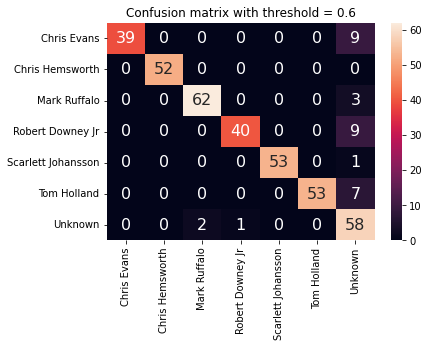

In [12]:
print("Phương pháp 1: Nearest candidate + Big dataset")
plot_confusion_matrix(big_nearest_recognition_result, y_test_big, threshold=0.6)

### Neighbour candidates

In [13]:
big_neighbour_recognition_result = test_threshold(threshold_list, x_train_big, x_test_big, y_train_big, type='neighbour')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


Phương pháp 2: Neigbour candidates + Big dataset
Accuracy score with threshold = 0.6: 0.9177377892030848


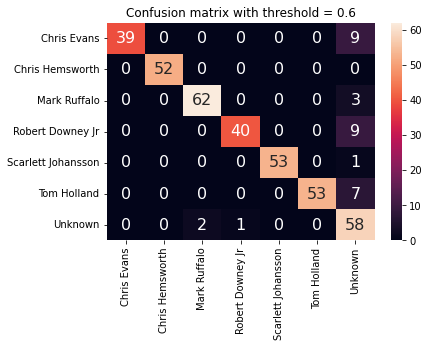

In [14]:
print("Phương pháp 2: Neigbour candidates + Big dataset")
plot_confusion_matrix(big_neighbour_recognition_result, y_test_big, threshold=0.6)

## Small dataset

### Nearest candidate

In [27]:
small_nearest_recognition_result = test_threshold(threshold_list, x_train_small, x_test_small, y_train_small, type='nearest')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


Phương pháp 1: Nearest candidate + Small dataset
Accuracy score with threshold = 0.6: 0.7100456621004566


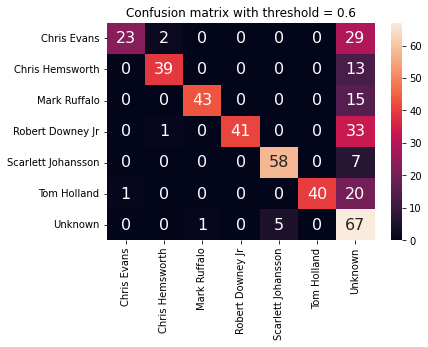

In [28]:
print("Phương pháp 1: Nearest candidate + Small dataset")
plot_confusion_matrix(small_nearest_recognition_result, y_test_small, threshold=0.6)

### Neighbour candidates

In [29]:
small_neighbour_recognition_result = test_threshold(threshold_list, x_train_small, x_test_small, y_train_small, type='neighbour')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


Phương pháp 1: Neighbour candidate + Small dataset
Accuracy score with threshold = 0.6: 0.7123287671232876


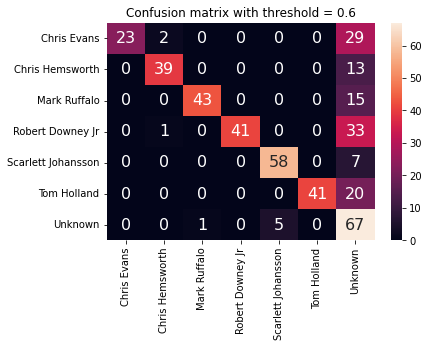

In [30]:
print("Phương pháp 1: Neighbour candidate + Small dataset")
plot_confusion_matrix(small_neighbour_recognition_result, y_test_small, threshold=0.6)